In [99]:
include("astrobee_se3_script.jl")
using Plots
using BenchmarkTools

In [100]:
function solve_gusto(model, N, MAX_ITERATIONS_NB, verbose = true)
    
    Xp,Up = initialize_trajectory(model, N)
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && it!=1 && it!=2 && it!=3 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    
        p0 = get_initial_constraint_dual_variable(SCPproblem, model)
        if verbose
#             println("dual variables:", p0)
        end
        # get solution
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # try shooting
        #x_shooting, sol_newton = solve_shooting(SCPproblem, model, p0)
    #     x_shooting = solve_shooting_once(SCPproblem, model, p0)
        #push!(x_shooting_all, x_shooting)

        # -----------
        # GuSTO Logic
        if it > 3
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end
    #         if convergence_metric(model,X,U,Xp,Up) <0.6
    #             println("Convergence metric very small. Decreasing Delta.")
    #             Delta = Delta0./(2^it)
    #         end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, X_all, U_all
end

solve_gusto (generic function with 2 methods)

In [101]:
function isInsideObstacle(x, model)
    isInside = false
    for obs in model.obstacles
        center = obs[1]
        radius = obs[2]
        if norm(x[1:3] - center) < radius
            isInside = true
            return isInside
        end
    end
    return isInside
end

isInsideObstacle (generic function with 1 method)

In [102]:
function plot_solution(model, X_all)
    N = length(X_all)

    idx = [1,2]
    local fig
    fig = plot()
    for iter = 1:length(X_all)
        X = X_all[iter]
        plot!(fig, X[1,:], X[2,:]; c=:blue)
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius; color=:red, fig=fig)
    end

    return fig
end

plot_solution (generic function with 2 methods)

In [111]:
N = 50
MAX_ITERATIONS_NB = 100

model = Astrobee()

model.x_init = [-0.25;0.4;0;  0;0;0;  0.;0.;0.; 1.;  0;0;0]
model.x_final = [0.7 ;-0.5;0;  0;0;0;  0.;0.;1.; 0.;  0;0;0]
model.tf_guess = 110.
model.convergence_threshold = 0.5
@show(model.obstacles)

time_start = time_ns()
isConverged, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, false)
gusto_solve_time = (time_ns() - time_start)/10^9
@show gusto_solve_time
@show size(X_all)
@show size(U_all)

model.obstacles = Any[Any[[0.0, 0.175, 0.0], 0.1], Any[[0.4, -0.1, 0.0], 0.1]]
gusto_solve_time = 2.358834291
size(X_all) = (7,)
size(U_all) = (7,)


(7,)

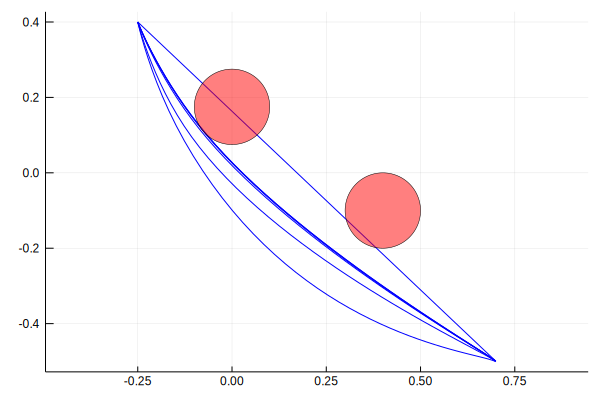

In [112]:
plot_solution(model, X_all)

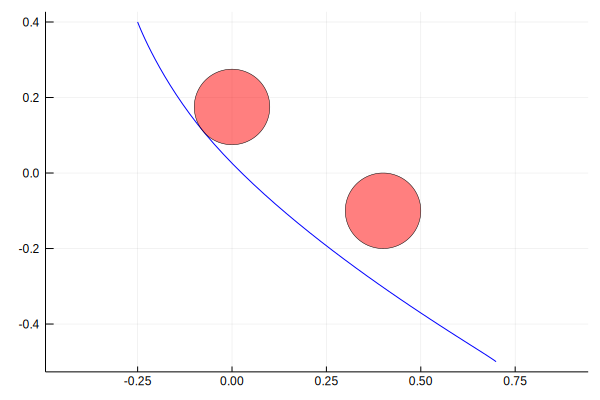

In [113]:
plot_solution(model, [X_all[end]])

In [114]:
N = 50
MAX_ITERATIONS_NB = 1

model = Astrobee()

model.x_init = [-0.25;0.4;0;  0;0;0;  0.;0.;0.; 1.;  0;0;0]
model.x_final = [0.7 ;-0.5;0;  0;0;0;  0.;0.;1.; 0.;  0;0;0]
model.tf_guess = 110.
model.convergence_threshold = 0.5
@show(model.obstacles)

time_start = time_ns()
isConverged, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, false)
gusto_solve_time = (time_ns() - time_start)/10^9
@show gusto_solve_time
@show size(X_all)
@show size(U_all)

model.obstacles = Any[Any[[0.0, 0.175, 0.0], 0.1], Any[[0.4, -0.1, 0.0], 0.1]]
gusto_solve_time = 0.36304466
size(X_all) = (2,)
size(U_all) = (2,)


(2,)